In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from rwse_checker.rwse import RWSE_Checker

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
ranges = list(range(1, 10)) + list(range(10, 101, 10))


def run_falsified_data(input_lines):
    result = dict()
    for line in input_lines:
        confusion_set, expected, sentence = line.strip().split('\t')
        rwse.set_confusion_sets([set(confusion_set.split(','))])
        for target in confusion_set.split(','):
            if target != expected:  # analyze mistakes only
                results = rwse.check(target, sentence, return_all=True)
                for magnitude in ranges:
                    suggestion, _ = rwse.evaluate(target, results, magnitude)
                    result.setdefault(magnitude, {'num_sentences': 0, 'num_matches': 0})
                    result[magnitude]['num_sentences'] += 1
                    if suggestion.lower() == expected.lower():  # no case discrimination in RWSE result, true positive
                        result[magnitude]['num_matches'] += 1
    return result


def run_original_data(input_lines):
    result = dict()
    for line in input_lines:
        confusion_set, target, sentence = line.strip().split('\t')
        rwse.set_confusion_sets([set(confusion_set.split(','))])
        results = rwse.check(target, sentence, return_all=True)
        for magnitude in ranges:
            suggestion, _ = rwse.evaluate(target, results, magnitude)
            result.setdefault(magnitude, {'num_sentences':0, 'num_matches':0})
            result[magnitude]['num_sentences'] += 1
            if suggestion.lower() != target.lower(): # no case discrimination in RWSE result
                result[magnitude]['num_matches'] += 1
    return result

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

In [3]:
report_file_name = 'output/report_magnitude_search_balanced.csv'
input_file_name = 'input/eng_news_2023_balanced-masked-sentences.csv'

if not os.path.exists(report_file_name):

    magnitude_search = dict()
    with open(input_file_name, 'r') as f:
        lines = f.readlines()[1:]  #skip Header

    print('Starting with false positives.')
    false_positive_result = run_original_data(lines)
    print('Starting with true positives.')
    true_positive_result = run_falsified_data(lines)

    with open(report_file_name, 'w') as output_file:

        print('magnitude', 'TP', 'TN', 'FP', 'FN', 'total', sep=';', file=output_file)
        for magnitude in ranges:

            print(f'Printing magnitude {magnitude}...')

            TP, TN, FP, FN = 0, 0, 0, 0
            total = 0
            num_sentences = false_positive_result[magnitude]['num_sentences']
            num_matches = false_positive_result[magnitude]['num_matches']
            TN = num_sentences - num_matches
            FP = num_matches
            total += num_sentences

            num_sentences = true_positive_result[magnitude]['num_sentences']
            num_matches = true_positive_result[magnitude]['num_matches']
            FN = num_sentences - num_matches
            TP = num_matches
            total += num_sentences

            print(magnitude, TP, TN, FP, FN, total, sep=';', file=output_file)


Starting with false positives.
Starting with true positives.
Printing magnitude 1...
Printing magnitude 2...
Printing magnitude 3...
Printing magnitude 4...
Printing magnitude 5...
Printing magnitude 6...
Printing magnitude 7...
Printing magnitude 8...
Printing magnitude 9...
Printing magnitude 10...
Printing magnitude 20...
Printing magnitude 30...
Printing magnitude 40...
Printing magnitude 50...
Printing magnitude 60...
Printing magnitude 70...
Printing magnitude 80...
Printing magnitude 90...
Printing magnitude 100...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


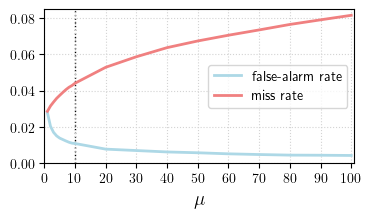

In [4]:
report_data = pd.read_csv('output/report_magnitude_search_balanced.csv', sep=';')
report_data.set_index('magnitude', inplace=True)
report_data['false-alarm rate'] = report_data['FP'] / (report_data['FP'] + report_data['TN']) #false-positive-rate
report_data['miss rate'] = report_data['FN'] / (report_data['FN'] + report_data['TP'])

y_1 = report_data['false-alarm rate']
y_2 = report_data['miss rate']
x = report_data.index

plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(4,2))
ax.set_xticks(list(range(0,101,10)))
#ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
ax.grid(color='lightgray', linestyle='dotted')
ax.margins(x=0.0102, y=0)
ax.set_xlabel("$\mu$", fontsize=14)

plt.plot(x, y_1, label="false-alarm rate", color="lightblue", linewidth=2)
plt.plot(x, y_2, label="miss rate", color="lightcoral", linewidth=2)
plt.plot([10, 10],[0, 0.085] , zorder=1, color="black", linewidth=1, linestyle="dotted")
plt.legend()
plt.show()